# exp002 EDA: 予測誤差分析

- 予測誤差の大きいサンプル分析
- 特徴量重要度の可視化
- 都道府県・市区町村別の誤差分析（マスター突合）

In [1]:
import sys
from pathlib import Path

# プロジェクトルート設定
notebook_dir = Path.cwd()
project_root = notebook_dir.parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# 出力ディレクトリ
output_dir = notebook_dir.parent / "outputs"

# 最新のOOF予測ファイルを取得
oof_files = sorted(output_dir.glob("oof_predictions_*.csv"))
latest_oof = oof_files[-1] if oof_files else None

importance_files = sorted(output_dir.glob("feature_importance_*.csv"))
latest_importance = importance_files[-1] if importance_files else None

print(f"OOF予測ファイル: {latest_oof.name}")
print(f"特徴量重要度ファイル: {latest_importance.name}")

OOF予測ファイル: oof_predictions_20251125_114002.csv
特徴量重要度ファイル: feature_importance_20251125_114002.csv


In [3]:
# OOF予測読み込み
oof_df = pl.read_csv(latest_oof)
print(f"OOF予測: {oof_df.shape}")

# 元の訓練データも読み込み
train = pl.read_csv(project_root / "data" / "raw" / "train.csv", infer_schema_length=100000)
print(f"訓練データ: {train.shape}")

# マスターデータ読み込み
area_master = pl.read_csv(project_root / "data" / "master" / "area_master.csv")
area_master = area_master.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
print(f"エリアマスター: {area_master.shape}")

OOF予測: (363924, 3)


訓練データ: (363924, 149)
エリアマスター: (1953, 5)


## 2. 誤差計算

In [4]:
# 誤差列を追加
oof_df = oof_df.with_columns([
    (pl.col("predicted") - pl.col("actual")).alias("error"),
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
])

# 基本統計
print("=" * 50)
print("誤差統計")
print("=" * 50)
print(f"平均誤差 (ME):      {oof_df['error'].mean():>15,.0f}円")
print(f"平均絶対誤差 (MAE): {oof_df['error'].abs().mean():>15,.0f}円")
print(f"MAPE:               {oof_df['ape'].mean():>15.2f}%")
print(f"中央値APE:          {oof_df['ape'].median():>15.2f}%")

誤差統計
平均誤差 (ME):               -3,689円
平均絶対誤差 (MAE):       5,753,757円
MAPE:                         28.26%
中央値APE:                    18.77%


## 3. 予測誤差の分布

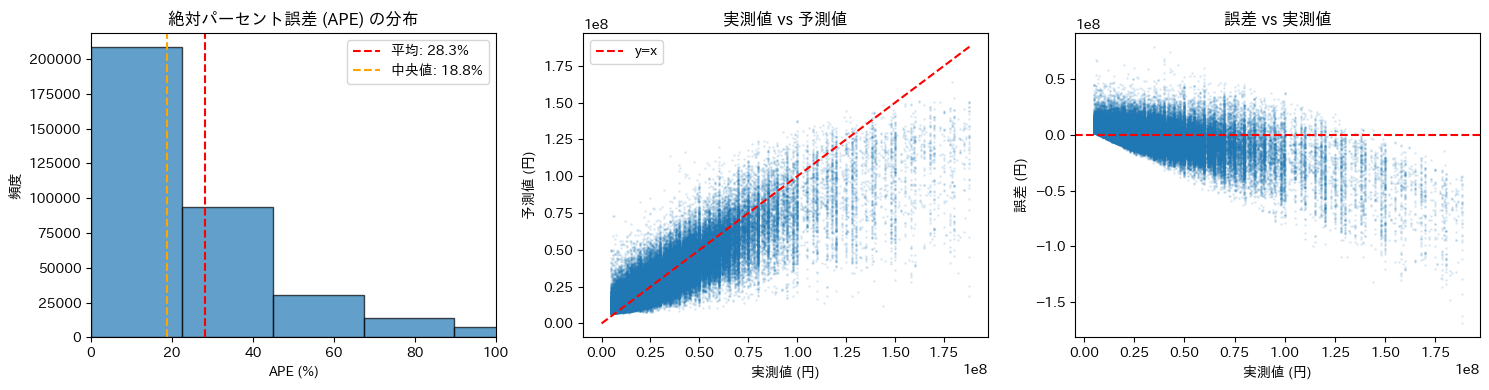

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# APE分布
ax = axes[0]
ape_values = oof_df["ape"].to_numpy()
ax.hist(ape_values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(ape_values.mean(), color='red', linestyle='--', label=f'平均: {ape_values.mean():.1f}%')
ax.axvline(np.median(ape_values), color='orange', linestyle='--', label=f'中央値: {np.median(ape_values):.1f}%')
ax.set_xlabel("APE (%)")
ax.set_ylabel("頻度")
ax.set_title("絶対パーセント誤差 (APE) の分布")
ax.legend()
ax.set_xlim(0, 100)

# 実測値 vs 予測値
ax = axes[1]
actual = oof_df["actual"].to_numpy()
predicted = oof_df["predicted"].to_numpy()
ax.scatter(actual, predicted, alpha=0.1, s=1)
ax.plot([0, actual.max()], [0, actual.max()], 'r--', label='y=x')
ax.set_xlabel("実測値 (円)")
ax.set_ylabel("予測値 (円)")
ax.set_title("実測値 vs 予測値")
ax.legend()

# 誤差 vs 実測値
ax = axes[2]
ax.scatter(actual, oof_df["error"].to_numpy(), alpha=0.1, s=1)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("実測値 (円)")
ax.set_ylabel("誤差 (円)")
ax.set_title("誤差 vs 実測値")

plt.tight_layout()
plt.show()

## 4. 予測誤差の大きいサンプル分析

In [6]:
# 元データとOOF予測を結合
train_with_oof = train.with_row_index("row_id").join(
    oof_df.rename({"id": "row_id"}),
    on="row_id",
    how="left"
)

# エリア情報を結合
train_with_oof = train_with_oof.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
train_with_area = train_with_oof.join(
    area_master.select(["addr1_1", "addr1_2", "都道府県名", "市区町村名"]),
    on=["addr1_1", "addr1_2"],
    how="left"
)

print(f"結合後データ: {train_with_area.shape}")

結合後データ: (363924, 156)


In [7]:
# APE上位10件
print("=" * 70)
print("APE上位10件（予測が大きく外れたサンプル）")
print("=" * 70)

top_errors = train_with_area.sort("ape", descending=True).head(10)
for i, row in enumerate(top_errors.iter_rows(named=True)):
    print(f"\n{i+1}. APE={row['ape']:.1f}%")
    print(f"   実測: {row['actual']:>12,.0f}円 | 予測: {row['predicted']:>12,.0f}円")
    print(f"   {row['都道府県名']} {row['市区町村名']}")
    print(f"   面積: {row['house_area']}㎡ | 築年: {row['year_built']}")

APE上位10件（予測が大きく外れたサンプル）



1. APE=1122.7%
   実測:    5,950,000円 | 予測:   72,749,878円
   東京都 青梅市
   面積: 2642.13㎡ | 築年: 199211

2. APE=1019.2%
   実測:    6,500,000円 | 予測:   72,749,878円
   東京都 青梅市
   面積: 2642.13㎡ | 築年: 199211

3. APE=907.1%
   実測:    5,900,000円 | 予測:   59,416,783円
   北海道 札幌市北区
   面積: 53.01㎡ | 築年: None

4. APE=891.1%
   実測:    5,000,000円 | 予測:   49,555,265円
   静岡県 静岡市清水区
   面積: 262.67㎡ | 築年: 198612

5. APE=891.1%
   実測:    5,000,000円 | 予測:   49,555,265円
   静岡県 静岡市清水区
   面積: 262.67㎡ | 築年: 198612

6. APE=885.8%
   実測:    5,000,000円 | 予測:   49,292,388円
   静岡県 静岡市清水区
   面積: 262.67㎡ | 築年: 198612

7. APE=885.8%
   実測:    5,000,000円 | 予測:   49,292,388円
   静岡県 静岡市清水区
   面積: 262.0㎡ | 築年: 198612

8. APE=791.3%
   実測:    5,000,000円 | 予測:   44,567,253円
   神奈川県 横須賀市
   面積: 171.0㎡ | 築年: 195005

9. APE=758.2%
   実測:    5,800,000円 | 予測:   49,777,848円
   愛知県 名古屋市名東区
   面積: 5706.0㎡ | 築年: 197008

10. APE=737.0%
   実測:    5,900,000円 | 予測:   49,380,791円
   滋賀県 彦根市
   面積: 253.06㎡ | 築年: None


## 5. 特徴量重要度

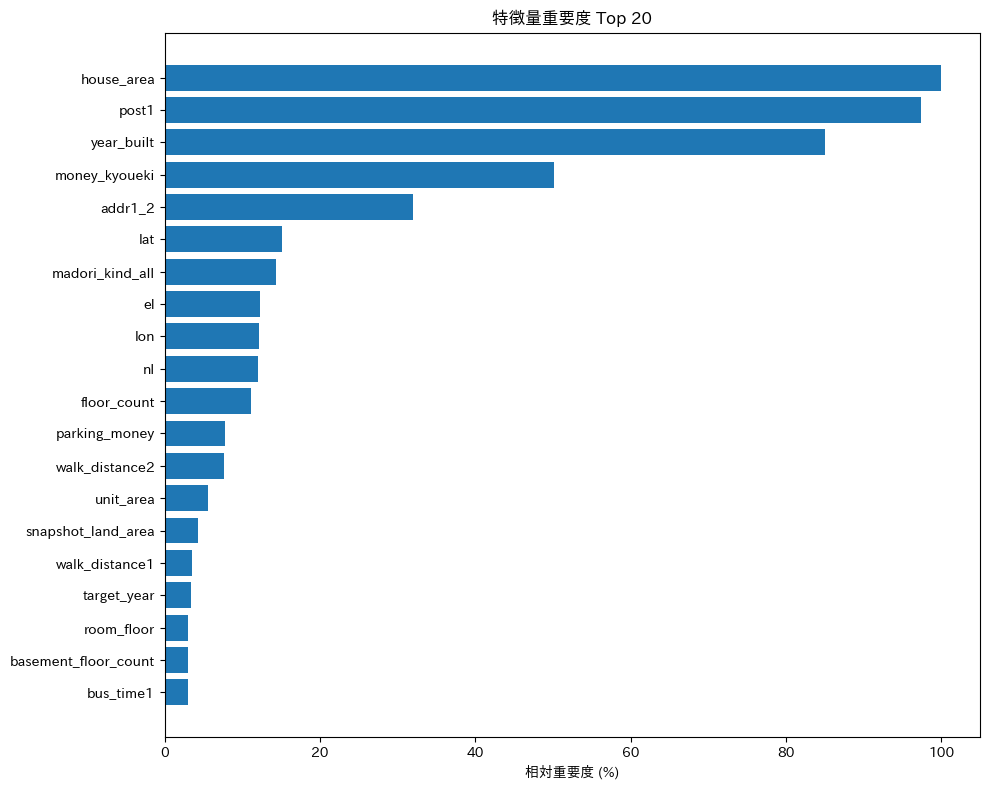

In [8]:
importance_df = pl.read_csv(latest_importance)
top_features = importance_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
features = top_features["feature"].to_list()[::-1]
importance = top_features["importance"].to_list()[::-1]

# 正規化
importance_norm = np.array(importance) / max(importance) * 100

ax.barh(features, importance_norm)
ax.set_xlabel("相対重要度 (%)")
ax.set_title("特徴量重要度 Top 20")

plt.tight_layout()
plt.show()

## 6. 都道府県別の誤差分析

In [9]:
pref_error = train_with_area.group_by("都道府県名").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("mean_ape", descending=True)

print("都道府県別 平均APE")
print("=" * 50)
print(f"{'都道府県':<10} {'平均APE':>10} {'中央値APE':>10} {'件数':>10}")
print("-" * 50)
for row in pref_error.iter_rows(named=True):
    print(f"{row['都道府県名']:<10} {row['mean_ape']:>10.2f}% {row['median_ape']:>10.2f}% {row['count']:>10,}")

都道府県別 平均APE
都道府県            平均APE     中央値APE         件数
--------------------------------------------------
和歌山県            51.14%      39.66%      3,330
奈良県             45.38%      29.16%      3,759
岐阜県             42.98%      28.09%      2,080
滋賀県             40.41%      23.93%      5,252
佐賀県             40.07%      28.36%        713
新潟県             38.72%      21.91%      1,404
静岡県             38.28%      25.40%      9,544
秋田県             38.07%      25.13%        347
徳島県             37.51%      21.90%        287
北海道             37.25%      22.38%      6,027
長崎県             36.66%      21.53%        778
青森県             36.56%      18.23%        638
茨城県             36.45%      24.31%      5,525
香川県             36.39%      24.53%        979
島根県             36.21%      20.90%        438
富山県             36.15%      18.18%        740
山梨県             35.97%      24.17%        389
三重県             35.57%      19.04%      1,122
兵庫県             35.34%      22.88%     22,778
山口県             34.

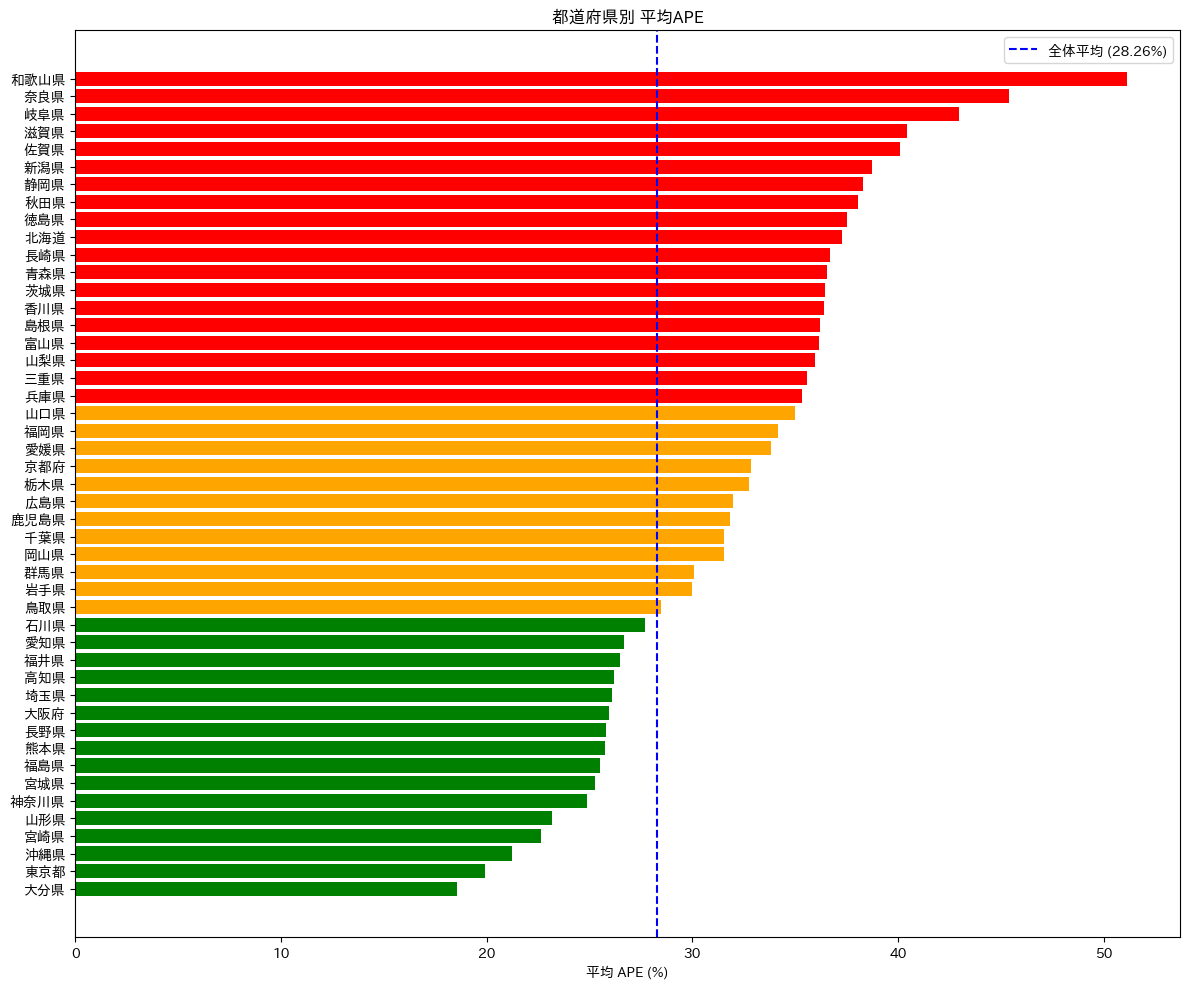

In [10]:
# 都道府県別APEの可視化
fig, ax = plt.subplots(figsize=(12, 10))
pref_sorted = pref_error.sort("mean_ape", descending=False)
prefs = pref_sorted["都道府県名"].to_list()
apes = pref_sorted["mean_ape"].to_list()

colors = ['red' if ape > 35 else 'orange' if ape > 28 else 'green' for ape in apes]
ax.barh(prefs, apes, color=colors)
ax.axvline(28.26, color='blue', linestyle='--', label='全体平均 (28.26%)')
ax.set_xlabel("平均 APE (%)")
ax.set_title("都道府県別 平均APE")
ax.legend()

plt.tight_layout()
plt.show()

## 7. 市区町村別の誤差分析

In [11]:
city_error = train_with_area.group_by(["都道府県名", "市区町村名"]).agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).filter(pl.col("count") >= 100).sort("mean_ape", descending=True)

print("市区町村別 平均APE（上位15、n>=100）")
print("=" * 60)
for i, row in enumerate(city_error.head(15).iter_rows(named=True)):
    print(f"{i+1:>2}. {row['都道府県名']} {row['市区町村名']:<10}: {row['mean_ape']:.2f}% (n={row['count']:,})")

市区町村別 平均APE（上位15、n>=100）
 1. 滋賀県 高島市       : 96.64% (n=124)
 2. 兵庫県 西脇市       : 89.71% (n=112)
 3. 静岡県 伊豆市       : 85.03% (n=123)
 4. 福岡県 大牟田市      : 77.11% (n=208)
 5. 北海道 北見市       : 73.80% (n=547)
 6. 和歌山県 橋本市       : 68.73% (n=155)
 7. 奈良県 桜井市       : 66.62% (n=230)
 8. 奈良県 大和高田市     : 66.47% (n=278)
 9. 愛媛県 宇和島市      : 65.99% (n=112)
10. 和歌山県 紀の川市      : 65.75% (n=252)
11. 兵庫県 神戸市北区     : 65.16% (n=739)
12. 神奈川県 三浦市       : 64.64% (n=180)
13. 福岡県 北九州市八幡東区  : 64.30% (n=243)
14. 京都府 舞鶴市       : 63.04% (n=290)
15. 滋賀県 甲賀市       : 62.98% (n=264)


In [12]:
print("\n市区町村別 平均APE（下位15、n>=100）")
print("=" * 60)
for i, row in enumerate(city_error.tail(15).iter_rows(named=True)):
    print(f"{i+1:>2}. {row['都道府県名']} {row['市区町村名']:<10}: {row['mean_ape']:.2f}% (n={row['count']:,})")


市区町村別 平均APE（下位15、n>=100）
 1. 大阪府 大阪市東成区    : 17.04% (n=434)
 2. 大阪府 大阪市西区     : 16.94% (n=1,457)
 3. 東京都 北区        : 16.82% (n=1,382)
 4. 神奈川県 川崎市幸区     : 16.79% (n=399)
 5. 大阪府 大阪市中央区    : 16.74% (n=1,833)
 6. 東京都 豊島区       : 16.73% (n=1,580)
 7. 東京都 港区        : 16.65% (n=2,593)
 8. 東京都 文京区       : 16.03% (n=1,418)
 9. 東京都 新宿区       : 15.88% (n=2,788)
10. 大阪府 大阪市浪速区    : 15.81% (n=727)
11. 東京都 品川区       : 15.64% (n=2,107)
12. 東京都 江東区       : 15.33% (n=3,013)
13. 東京都 台東区       : 15.20% (n=1,753)
14. 東京都 千代田区      : 14.12% (n=523)
15. 東京都 中央区       : 13.15% (n=2,050)


## 8. 価格帯別の誤差分析

In [13]:
# 価格帯を作成（money_roomは円単位、最小490万円〜最大1.88億円）
train_with_area = train_with_area.with_columns([
    pl.when(pl.col("actual") < 10_000_000).then(pl.lit("1_~1000万"))
    .when(pl.col("actual") < 15_000_000).then(pl.lit("2_1000~1500万"))
    .when(pl.col("actual") < 20_000_000).then(pl.lit("3_1500~2000万"))
    .when(pl.col("actual") < 30_000_000).then(pl.lit("4_2000~3000万"))
    .when(pl.col("actual") < 50_000_000).then(pl.lit("5_3000~5000万"))
    .otherwise(pl.lit("6_5000万~"))
    .alias("price_range")
])

price_error = train_with_area.group_by("price_range").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("price_range")

print("価格帯別 平均APE")
print("=" * 60)
print(f"{'価格帯':<15} {'平均APE':>10} {'中央値APE':>10} {'件数':>10}")
print("-" * 60)
for row in price_error.iter_rows(named=True):
    label = row['price_range'].split('_')[1]  # プレフィックス除去
    print(f"{label:<15} {row['mean_ape']:>10.2f}% {row['median_ape']:>10.2f}% {row['count']:>10,}")

価格帯別 平均APE
価格帯                  平均APE     中央値APE         件数
------------------------------------------------------------
~1000万               75.19%      64.32%     48,356
1000~1500万           30.30%      21.48%     57,370
1500~2000万           22.56%      17.88%     62,787
2000~3000万           17.33%      14.07%     94,034
3000~5000万           17.09%      14.43%     75,203
5000万~               22.14%      19.39%     26,174


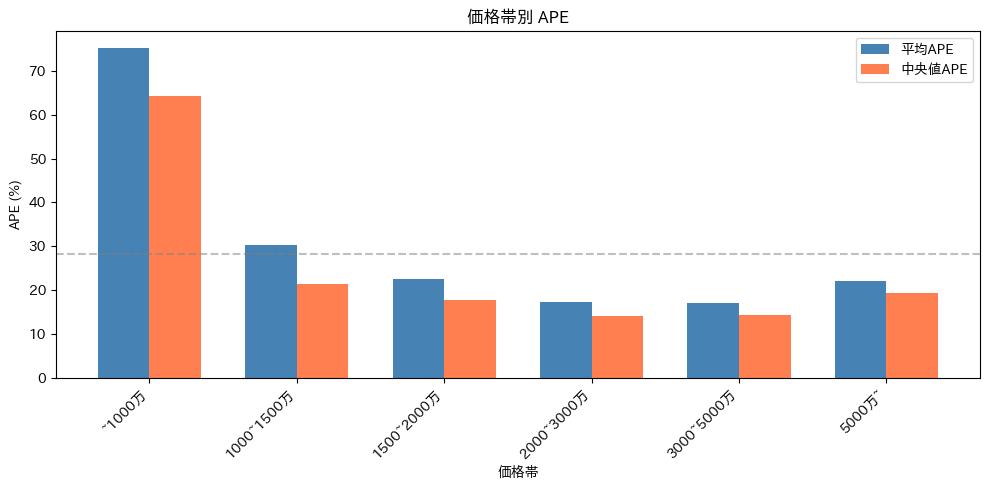

In [14]:
# 価格帯別APEの可視化
fig, ax = plt.subplots(figsize=(10, 5))

labels = [r['price_range'].split('_')[1] for r in price_error.iter_rows(named=True)]
mean_apes = price_error['mean_ape'].to_list()
median_apes = price_error['median_ape'].to_list()

x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, mean_apes, width, label='平均APE', color='steelblue')
ax.bar(x + width/2, median_apes, width, label='中央値APE', color='coral')

ax.set_ylabel('APE (%)')
ax.set_xlabel('価格帯')
ax.set_title('価格帯別 APE')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.axhline(28.26, color='gray', linestyle='--', alpha=0.5, label='全体平均')

plt.tight_layout()
plt.show()

## 9. 築年数別の誤差分析

In [15]:
# 築年を抽出（year_builtは YYYYMM形式、例: 199211 → 1992年）
train_with_area = train_with_area.with_columns([
    (pl.col("year_built") // 100).alias("built_year")
])

# 築年数を計算（2024年基準）
train_with_area = train_with_area.with_columns([
    (2024 - pl.col("built_year")).alias("building_age")
])

# 築年数帯を作成
train_with_area = train_with_area.with_columns([
    pl.when(pl.col("building_age") < 5).then(pl.lit("1_~5年"))
    .when(pl.col("building_age") < 10).then(pl.lit("2_5~10年"))
    .when(pl.col("building_age") < 20).then(pl.lit("3_10~20年"))
    .when(pl.col("building_age") < 30).then(pl.lit("4_20~30年"))
    .when(pl.col("building_age") < 40).then(pl.lit("5_30~40年"))
    .otherwise(pl.lit("6_40年~"))
    .alias("age_range")
])

age_error = train_with_area.group_by("age_range").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("age_range")

print("築年数帯別 平均APE")
print("=" * 60)
print(f"{'築年数':<15} {'平均APE':>10} {'中央値APE':>10} {'件数':>10}")
print("-" * 60)
for row in age_error.iter_rows(named=True):
    label = row['age_range'].split('_')[1]
    print(f"{label:<15} {row['mean_ape']:>10.2f}% {row['median_ape']:>10.2f}% {row['count']:>10,}")

築年数帯別 平均APE
築年数                  平均APE     中央値APE         件数
------------------------------------------------------------
~5年                  42.41%      24.07%      5,722
5~10年                17.52%      13.47%     21,637
10~20年               19.27%      14.38%     57,193
20~30年               24.12%      17.13%     84,310
30~40年               30.74%      21.42%     78,374
40年~                 35.29%      22.78%    116,688


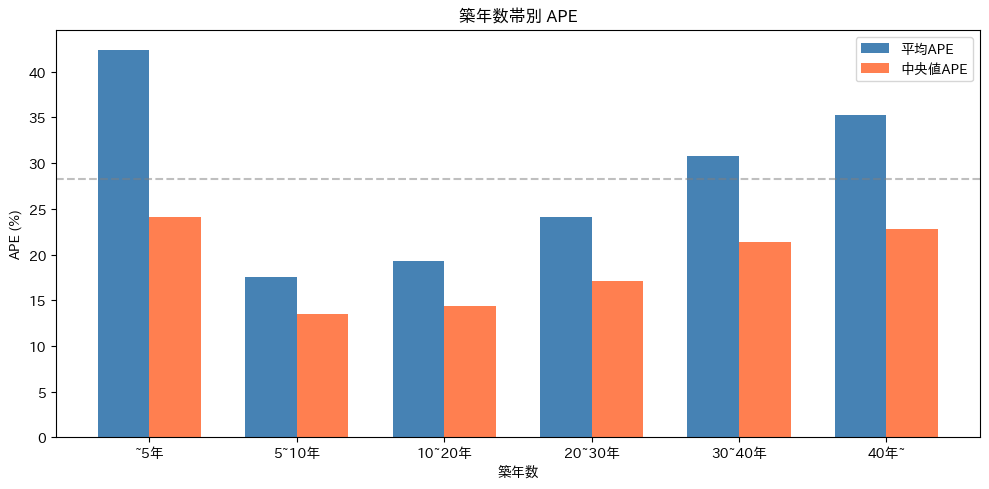

In [16]:
# 築年数別APEの可視化
fig, ax = plt.subplots(figsize=(10, 5))

labels = [r['age_range'].split('_')[1] for r in age_error.iter_rows(named=True)]
mean_apes = age_error['mean_ape'].to_list()
median_apes = age_error['median_ape'].to_list()

x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, mean_apes, width, label='平均APE', color='steelblue')
ax.bar(x + width/2, median_apes, width, label='中央値APE', color='coral')

ax.set_ylabel('APE (%)')
ax.set_xlabel('築年数')
ax.set_title('築年数帯別 APE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.axhline(28.26, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 10. サマリー

In [17]:
print("="*60)
print("EDA サマリー")
print("="*60)

print("""
【モデル性能】
  - CV MAPE: 28.26%
  - 特徴量数: 84個（除外: 46個）

【誤差傾向】
  - 高APE都道府県: 和歌山県(51%)、奈良県(45%)、岐阜県(43%)
  - 低APE都道府県: 大分県(19%)、東京都(20%)、沖縄県(21%)
  - 低価格帯（~1000万）のAPEが特に高い (75%)
  - 築5~10年が最も予測しやすい (17.5%)

【重要特徴量 Top 5】
  1. house_area（専有面積）
  2. post1（郵便番号上3桁）
  3. year_built（築年）
  4. money_kyoueki（共益費）
  5. addr1_2（市区町村コード）

【次のアクション候補】
  1. 地域特性を反映した特徴量追加（都道府県ダミー等）
  2. 低価格帯（~1000万）の外れ値対応
  3. 築年数の非線形変換
  4. 面積あたり単価の特徴量追加
""")

EDA サマリー

【モデル性能】
  - CV MAPE: 28.26%
  - 特徴量数: 84個（除外: 46個）

【誤差傾向】
  - 高APE都道府県: 和歌山県(51%)、奈良県(45%)、岐阜県(43%)
  - 低APE都道府県: 大分県(19%)、東京都(20%)、沖縄県(21%)
  - 低価格帯（~1000万）のAPEが特に高い (75%)
  - 築5~10年が最も予測しやすい (17.5%)

【重要特徴量 Top 5】
  1. house_area（専有面積）
  2. post1（郵便番号上3桁）
  3. year_built（築年）
  4. money_kyoueki（共益費）
  5. addr1_2（市区町村コード）

【次のアクション候補】
  1. 地域特性を反映した特徴量追加（都道府県ダミー等）
  2. 低価格帯（~1000万）の外れ値対応
  3. 築年数の非線形変換
  4. 面積あたり単価の特徴量追加

